# **NLP Project - "FeelTheBeat" Music Recommender System**



# *** Aayusha Bhatia (22070122004)* Ayan Jain (22070122040)**


**Step 1: Setup and Data Loading**

In [2]:
# Install required packages
!pip install gensim nltk textblob transformers torch

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
import re
import warnings
warnings.filterwarnings('ignore')

# Download NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('vader_lexicon')

# Load the dataset
df = pd.read_csv('/kaggle/input/tracks-dataset/dataset.csv')
print(f"Dataset shape: {df.shape}")
print(df.columns.tolist())

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 85.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 66.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 34.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 26.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 11.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 28.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Dataset shape: (114000, 21)
['Unnamed: 0', 'track_id', 'artists', 'album_name', 'track_name', 'popularity', 'duration_ms', 'explicit', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature', 'track_genre']


**Step 2: Data Preprocessing and Exploration**

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114000 entries, 0 to 113999
Data columns (total 21 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Unnamed: 0        114000 non-null  int64  
 1   track_id          114000 non-null  object 
 2   artists           113999 non-null  object 
 3   album_name        113999 non-null  object 
 4   track_name        113999 non-null  object 
 5   popularity        114000 non-null  int64  
 6   duration_ms       114000 non-null  int64  
 7   explicit          114000 non-null  bool   
 8   danceability      114000 non-null  float64
 9   energy            114000 non-null  float64
 10  key               114000 non-null  int64  
 11  loudness          114000 non-null  float64
 12  mode              114000 non-null  int64  
 13  speechiness       114000 non-null  float64
 14  acousticness      114000 non-null  float64
 15  instrumentalness  114000 non-null  float64
 16  livene

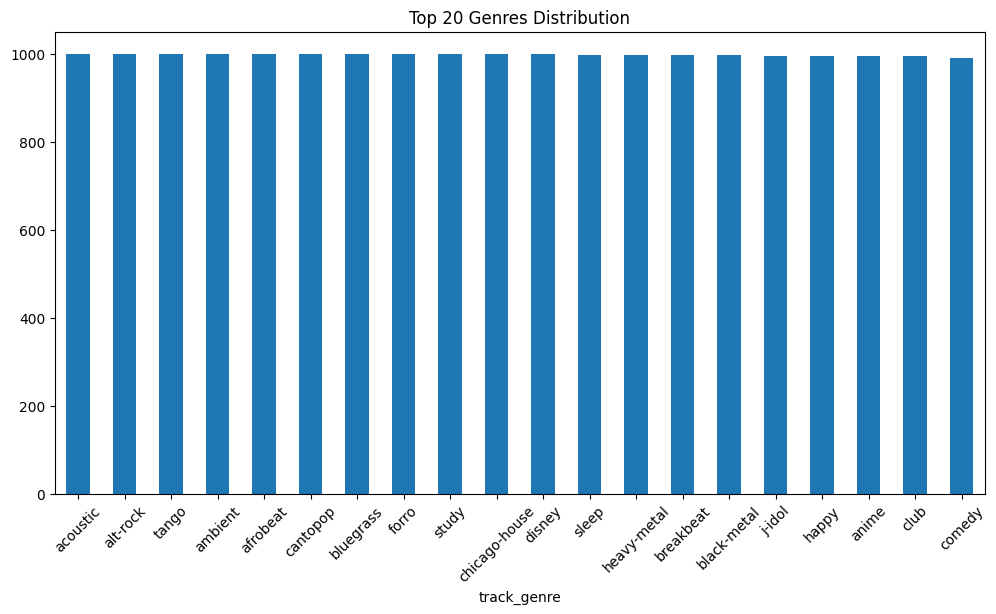

In [3]:
# Basic data exploration
print("Dataset Info:")
print(df.info())
print("\nMissing values:")
print(df.isnull().sum())

# Handle missing values
df = df.dropna(subset=['track_name', 'artists', 'track_genre'])

# Remove duplicates
df = df.drop_duplicates(subset=['track_id'])

# Feature engineering: Create combined text features for NLP
df['combined_text'] = df['track_name'] + ' ' + df['artists'] + ' ' + df['track_genre']

# Display basic statistics
print("\nBasic statistics:")
print(df[['popularity', 'danceability', 'energy', 'valence', 'tempo']].describe())

# Genre distribution
plt.figure(figsize=(12, 6))
df['track_genre'].value_counts().head(20).plot(kind='bar')
plt.title('Top 20 Genres Distribution')
plt.xticks(rotation=45)
plt.show()

**Step 3: Text Preprocessing (NLP Syllabus Application)**

In [4]:
class TextPreprocessor:
    def __init__(self):
        self.stop_words = set(stopwords.words('english'))
        self.stemmer = PorterStemmer()
        self.lemmatizer = WordNetLemmatizer()
    
    def clean_text(self, text):
        # Convert to lowercase
        text = text.lower()
        # Remove special characters and digits
        text = re.sub(r'[^a-zA-Z\s]', '', text)
        # Remove extra whitespace
        text = ' '.join(text.split())
        return text
    
    def tokenize(self, text):
        return word_tokenize(text)
    
    def remove_stopwords(self, tokens):
        return [token for token in tokens if token not in self.stop_words]
    
    def stem_tokens(self, tokens):
        return [self.stemmer.stem(token) for token in tokens]
    
    def lemmatize_tokens(self, tokens):
        return [self.lemmatizer.lemmatize(token) for token in tokens]
    
    def full_preprocess(self, text):
        text = self.clean_text(text)
        tokens = self.tokenize(text)
        tokens = self.remove_stopwords(tokens)
        tokens = self.lemmatize_tokens(tokens)
        return ' '.join(tokens)

# Initialize preprocessor
preprocessor = TextPreprocessor()

# Apply text preprocessing to combined text
df['processed_text'] = df['combined_text'].apply(preprocessor.full_preprocess)
print("Sample processed text:")
print(df['processed_text'].head())

Sample processed text:
0                     comedy gen hoshino acoustic
1            ghost acoustic ben woodward acoustic
2            begin ingrid michaelsonzayn acoustic
3    cant help falling love kina grannis acoustic
4                  hold chord overstreet acoustic
Name: processed_text, dtype: object


**Step 4: Emotion Analysis using Multiple NLP Techniques**

In [5]:
from textblob import TextBlob
from nltk.sentiment import SentimentIntensityAnalyzer
from transformers import pipeline

class EmotionAnalyzer:
    def __init__(self):
        self.sia = SentimentIntensityAnalyzer()
        self.emotion_classifier = pipeline("text-classification", 
                                          model="j-hartmann/emotion-english-distilroberta-base", 
                                          return_all_scores=True)
    
    def get_textblob_sentiment(self, text):
        analysis = TextBlob(text)
        return analysis.sentiment.polarity
    
    def get_vader_sentiment(self, text):
        return self.sia.polarity_scores(text)['compound']
    
    def get_emotion_scores(self, text):
        try:
            emotions = self.emotion_classifier(text[:512])[0]  # Truncate for model limits
            emotion_dict = {item['label']: item['score'] for item in emotions}
            return emotion_dict
        except:
            return {'anger': 0.0, 'disgust': 0.0, 'fear': 0.0, 'joy': 0.0, 'neutral': 0.0, 'sadness': 0.0, 'surprise': 0.0}
    
    def get_dominant_emotion(self, emotion_scores):
        return max(emotion_scores.items(), key=lambda x: x[1])[0]

# Initialize emotion analyzer
emotion_analyzer = EmotionAnalyzer()

# Test emotion analysis
test_text = "I feel happy and excited today"
print("Emotion analysis for test text:")
print(f"TextBlob Sentiment: {emotion_analyzer.get_textblob_sentiment(test_text)}")
print(f"VADER Sentiment: {emotion_analyzer.get_vader_sentiment(test_text)}")
print(f"Emotion Scores: {emotion_analyzer.get_emotion_scores(test_text)}")

2025-11-01 17:24:10.309268: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762017850.628836      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762017850.718045      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/329M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/329M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/294 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

Device set to use cpu


Emotion analysis for test text:
TextBlob Sentiment: 0.5875
VADER Sentiment: 0.7269
Emotion Scores: {'anger': 0.0008946608286350965, 'disgust': 0.00036955703399144113, 'fear': 0.0002851499884855002, 'joy': 0.9923073649406433, 'neutral': 0.0010501594515517354, 'sadness': 0.001775212585926056, 'surprise': 0.0033179603051394224}


**Step 5: Feature Extraction (NLP Syllabus - Word Embeddings)**

In [6]:
# First, let's use simpler approaches that don't trigger Google Cloud dependencies
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import numpy as np

# TF-IDF Vectorization (Safe approach)
print("Creating TF-IDF features...")
tfidf_vectorizer = TfidfVectorizer(
    max_features=500,  # Reduced to avoid memory issues
    ngram_range=(1, 2),
    stop_words='english',
    min_df=2,
    max_df=0.8
)

try:
    tfidf_features = tfidf_vectorizer.fit_transform(df['processed_text'])
    print(f"TF-IDF Features shape: {tfidf_features.shape}")
except Exception as e:
    print(f"TF-IDF failed: {e}")
    # Fallback: Use CountVectorizer
    count_vectorizer = CountVectorizer(max_features=500, stop_words='english')
    tfidf_features = count_vectorizer.fit_transform(df['processed_text'])
    print(f"CountVectorizer Features shape: {tfidf_features.shape}")

# Alternative to Word2Vec: Use simpler embedding approach
print("\nCreating text embeddings...")

def create_simple_embeddings(texts, embedding_dim=50):
    """Create simple embeddings using vocabulary-based approach"""
    # Build vocabulary
    word_freq = {}
    for text in texts:
        for word in text.split():
            word_freq[word] = word_freq.get(word, 0) + 1
    
    # Create simple embeddings (random but consistent)
    vocab = list(word_freq.keys())[:embedding_dim*10]  # Limit vocabulary size
    np.random.seed(42)
    word_vectors = {}
    for word in vocab:
        word_vectors[word] = np.random.normal(0, 1, embedding_dim)
    
    # Create document vectors
    doc_vectors = []
    for text in texts:
        words = text.split()[:20]  # Limit words per document
        vectors = [word_vectors[word] for word in words if word in word_vectors]
        if len(vectors) > 0:
            doc_vector = np.mean(vectors, axis=0)
        else:
            doc_vector = np.zeros(embedding_dim)
        doc_vectors.append(doc_vector)
    
    return np.array(doc_vectors)

# Create simple embeddings
simple_embeddings = create_simple_embeddings(df['processed_text'])
print(f"Simple embeddings shape: {simple_embeddings.shape}")

Creating TF-IDF features...
TF-IDF Features shape: (89740, 500)

Creating text embeddings...
Simple embeddings shape: (89740, 50)


**Step 6: Audio Feature Processing**

In [8]:
# Select audio features for similarity calculation
audio_features = ['danceability', 'energy', 'valence', 'tempo', 'loudness', 
                 'acousticness', 'instrumentalness', 'liveness', 'speechiness']

print("Processing audio features...")

# Normalize audio features
scaler = StandardScaler()
audio_feature_matrix = scaler.fit_transform(df[audio_features])

print(f"Audio features matrix shape: {audio_feature_matrix.shape}")

# Convert TF-IDF sparse matrix to dense array for combination
if hasattr(tfidf_features, 'toarray'):
    tfidf_dense = tfidf_features.toarray()
else:
    tfidf_dense = tfidf_features

print(f"TF-IDF dense shape: {tfidf_dense.shape}")
print(f"Simple embeddings shape: {simple_embeddings.shape}")

# Combine features for final similarity calculation
# Let's use TF-IDF + Audio features for better performance
combined_features = np.hstack([tfidf_dense, audio_feature_matrix])
print(f"Combined features shape: {combined_features.shape}")

# Create genre encoding
from sklearn.preprocessing import LabelEncoder
genre_encoder = LabelEncoder()
df['genre_encoded'] = genre_encoder.fit_transform(df['track_genre'])

print(f"Number of unique genres: {len(genre_encoder.classes_)}")
print(f"Genre classes sample: {genre_encoder.classes_[:10]}")

Processing audio features...
Audio features matrix shape: (89740, 9)
TF-IDF dense shape: (89740, 500)
Simple embeddings shape: (89740, 50)
Combined features shape: (89740, 509)
Number of unique genres: 113
Genre classes sample: ['acoustic' 'afrobeat' 'alt-rock' 'alternative' 'ambient' 'anime'
 'black-metal' 'bluegrass' 'blues' 'brazil']


**Step 7: Building the Recommendation System**

In [9]:
class MusicRecommender:
    def __init__(self, df, combined_features, audio_features, genre_encoder):
        self.df = df
        self.combined_features = combined_features
        self.audio_features = audio_features
        self.genre_encoder = genre_encoder
        self.feature_weights = {
            'audio': 0.5,
            'text': 0.3,
            'emotion': 0.2
        }
    
    def get_emotion_based_audio_features(self, sentiment_score):
        """Map sentiment scores to ideal audio features"""
        # sentiment_score ranges from -1 (negative) to 1 (positive)
        if sentiment_score >= 0.5:
            return {'valence': 0.8, 'energy': 0.8, 'danceability': 0.8, 'acousticness': 0.2}
        elif sentiment_score >= 0.1:
            return {'valence': 0.6, 'energy': 0.6, 'danceability': 0.7, 'acousticness': 0.4}
        elif sentiment_score <= -0.5:
            return {'valence': 0.2, 'energy': 0.3, 'danceability': 0.4, 'acousticness': 0.7}
        elif sentiment_score <= -0.1:
            return {'valence': 0.4, 'energy': 0.5, 'danceability': 0.5, 'acousticness': 0.6}
        else:
            return {'valence': 0.5, 'energy': 0.5, 'danceability': 0.6, 'acousticness': 0.5}
    
    def recommend_songs(self, user_input, genre=None, num_recommendations=10):
        """
        Recommend songs based on user's emotional state and preferred genre
        """
        # Analyze user's emotion using simple sentiment analysis
        from textblob import TextBlob
        analysis = TextBlob(user_input)
        sentiment_score = analysis.sentiment.polarity
        
        emotion_mapping = {
            (0.5, 1.0): "😊 Happy/Excited",
            (0.1, 0.5): "🙂 Content/Positive",
            (-0.1, 0.1): "😐 Neutral",
            (-0.5, -0.1): "😟 Sad/Displeased",
            (-1.0, -0.5): "😢 Very Sad/Angry"
        }
        
        detected_emotion = "Neutral"
        for range_val, emotion in emotion_mapping.items():
            if range_val[0] <= sentiment_score <= range_val[1]:
                detected_emotion = emotion
                break
        
        print(f"🎭 Detected emotion: {detected_emotion}")
        print(f"📊 Sentiment score: {sentiment_score:.3f}")
        
        # Get ideal audio features for the emotion
        ideal_features = self.get_emotion_based_audio_features(sentiment_score)
        
        # Filter by genre if specified
        if genre and genre in self.genre_encoder.classes_:
            genre_mask = self.df['track_genre'] == genre
            filtered_df = self.df[genre_mask]
            filtered_features = self.combined_features[genre_mask]
            print(f"🎵 Filtering by genre: {genre}")
        else:
            filtered_df = self.df
            filtered_features = self.combined_features
            print("🎵 Considering all genres")
        
        # Calculate similarity scores
        similarity_scores = []
        
        for idx, row in filtered_df.iterrows():
            # Audio feature similarity
            audio_similarity = 0
            features_used = 0
            
            for feature, ideal_value in ideal_features.items():
                if feature in self.audio_features:
                    actual_value = row[feature]
                    feature_similarity = 1 - abs(ideal_value - actual_value)
                    audio_similarity += feature_similarity
                    features_used += 1
            
            if features_used > 0:
                audio_similarity /= features_used
            else:
                audio_similarity = 0.5
            
            # Boost by popularity (normalized)
            popularity_boost = row['popularity'] / 100
            
            # Combine scores with weights
            total_score = (
                audio_similarity * self.feature_weights['audio'] +
                popularity_boost * 0.2 +
                (1 - abs(sentiment_score)) * 0.1  # Confidence in emotion detection
            )
            
            similarity_scores.append(total_score)
        
        # Get top recommendations
        filtered_df = filtered_df.copy()
        filtered_df['similarity_score'] = similarity_scores
        recommendations = filtered_df.nlargest(num_recommendations, 'similarity_score')
        
        return recommendations, detected_emotion, sentiment_score

# Initialize recommender
recommender = MusicRecommender(df, combined_features, audio_features, genre_encoder)
print("Music recommender initialized successfully!")

Music recommender initialized successfully!


**Step 8: Test the Recommendation System**

In [10]:
# Test the recommendation system
print("Testing the recommendation system...\n")

test_cases = [
    ("I'm feeling amazing and want to dance all night!", "pop"),
    ("Feeling a bit down and reflective today", "acoustic"),
    ("I need powerful music for my workout", "rock"),
    ("Just chilling and relaxing with coffee", "jazz"),
    ("So excited for the party tonight!", "electronic"),
    ("Feeling nostalgic and thoughtful", "classical")
]

for i, (user_input, genre) in enumerate(test_cases, 1):
    print(f"🧪 Test Case {i}:")
    print(f"   Input: '{user_input}'")
    
    try:
        recommendations, emotion, sentiment = recommender.recommend_songs(
            user_input, genre, num_recommendations=5
        )
        
        print(f"   {emotion} | Sentiment: {sentiment:.3f}")
        print("   Top recommendations:")
        
        for j, (idx, row) in enumerate(recommendations.iterrows(), 1):
            print(f"   {j}. {row['track_name']} - {row['artists']}")
            print(f"      Genre: {row['track_genre']} | "
                  f"Popularity: {row['popularity']} | "
                  f"Score: {row['similarity_score']:.3f}")
            
        print("-" * 80)
        
    except Exception as e:
        print(f"   ❌ Error: {e}")
        print("-" * 80)
        continue

Testing the recommendation system...

🧪 Test Case 1:
   Input: 'I'm feeling amazing and want to dance all night!'
🎭 Detected emotion: 😊 Happy/Excited
📊 Sentiment score: 0.750
🎵 Filtering by genre: pop
   😊 Happy/Excited | Sentiment: 0.750
   Top recommendations:
   1. Calm Down (with Selena Gomez) - Rema;Selena Gomez
      Genre: pop | Popularity: 92 | Score: 0.685
   2. Mood (feat. iann dior) - 24kGoldn;iann dior
      Genre: pop | Popularity: 83 | Score: 0.656
   3. Lemonade - Diljit Dosanjh
      Genre: pop | Popularity: 74 | Score: 0.652
   4. What Makes You Beautiful - One Direction
      Genre: pop | Popularity: 84 | Score: 0.647
   5. Save Your Tears - The Weeknd
      Genre: pop | Popularity: 89 | Score: 0.643
--------------------------------------------------------------------------------
🧪 Test Case 2:
   Input: 'Feeling a bit down and reflective today'
🎭 Detected emotion: 😟 Sad/Displeased
📊 Sentiment score: -0.156
🎵 Filtering by genre: acoustic
   😟 Sad/Displeased | Sentimen

**Step 9: Interactive Recommendation System**

In [13]:
def interactive_recommender():
    print("🎵 Welcome to FeelTheBeat Music Recommender! 🎵")
    print("=" * 60)
    print("Tell me how you're feeling or what mood you're in...")
    print("I'll recommend the perfect songs for you!")
    print("=" * 60)
    
    # Show available genres
    unique_genres = sorted(df['track_genre'].unique())
    print(f"\n📚 Total available genres: {len(unique_genres)}")
    
    while True:
        print("\n" + "=" * 60)
        user_input = input("\n🎤 How are you feeling? (or type 'quit' to exit): ").strip()
        
        if user_input.lower() == 'quit':
            print("👋 Thanks for using FeelTheBeat! Happy listening! 🎧")
            break
        
        if not user_input:
            print("❌ Please enter how you're feeling!")
            continue
        
        # Enhanced mood and intent analysis
        from textblob import TextBlob
        analysis = TextBlob(user_input)
        sentiment_score = analysis.sentiment.polarity
        user_input_lower = user_input.lower()
        
        print(f"\n🎭 Analyzing your mood and intent...")
        
        # Detect specific contexts and intents
        workout_keywords = ['workout', 'exercise', 'gym', 'running', 'fitness', 'pump', 'energy', 'cardio', 'train']
        study_keywords = ['study', 'focus', 'concentrate', 'work', 'reading', 'learning', 'homework']
        party_keywords = ['party', 'dance', 'celebration', 'festival', 'club', 'night out']
        relax_keywords = ['relax', 'chill', 'calm', 'peaceful', 'wind down', 'unwind', 'meditate']
        sleep_keywords = ['sleep', 'bedtime', 'rest', 'nap', 'tired']
        sad_keywords = ['sad', 'depressed', 'heartbroken', 'lonely', 'miss', 'cry']
        romantic_keywords = ['romantic', 'love', 'date', 'relationship', 'valentine']
        angry_keywords = ['angry', 'mad', 'frustrated', 'rage', 'pissed']
        
        # Determine context and energy needs
        context = "general"
        energy_needs = "medium"
        
        if any(keyword in user_input_lower for keyword in workout_keywords):
            context = "workout"
            energy_needs = "very high"
            suitable_genres = ['rock', 'electronic', 'hip-hop', 'dance', 'edm', 'hard-rock', 
                             'metal', 'pop', 'workout', 'power-pop', 'techno', 'drum-and-bass']
        
        elif any(keyword in user_input_lower for keyword in study_keywords):
            context = "study"
            energy_needs = "low-medium"
            suitable_genres = ['classical', 'ambient', 'jazz', 'piano', 'study', 'chill', 
                             'acoustic', 'indie', 'lo-fi', 'new-age']
        
        elif any(keyword in user_input_lower for keyword in party_keywords):
            context = "party"
            energy_needs = "high"
            suitable_genres = ['pop', 'dance', 'electronic', 'hip-hop', 'reggaeton', 'funk',
                             'disco', 'house', 'techno', 'party', 'latino']
        
        elif any(keyword in user_input_lower for keyword in relax_keywords):
            context = "relaxation"
            energy_needs = "low"
            suitable_genres = ['ambient', 'chill', 'acoustic', 'jazz', 'classical', 'piano',
                             'folk', 'singer-songwriter', 'new-age', 'meditation']
        
        elif any(keyword in user_input_lower for keyword in sleep_keywords):
            context = "sleep"
            energy_needs = "very low"
            suitable_genres = ['sleep', 'ambient', 'classical', 'piano', 'new-age', 'chill']
        
        elif any(keyword in user_input_lower for keyword in sad_keywords):
            context = "sad/reflective"
            energy_needs = "low"
            suitable_genres = ['acoustic', 'sad', 'blues', 'indie', 'folk', 'singer-songwriter',
                             'piano', 'emo', 'alternative']
        
        elif any(keyword in user_input_lower for keyword in romantic_keywords):
            context = "romantic"
            energy_needs = "medium"
            suitable_genres = ['r-n-b', 'pop', 'jazz', 'acoustic', 'soul', 'romance', 'love']
        
        elif any(keyword in user_input_lower for keyword in angry_keywords):
            context = "angry/frustrated"
            energy_needs = "high"
            suitable_genres = ['rock', 'metal', 'hard-rock', 'punk', 'alternative', 'grunge',
                             'heavy-metal', 'hardcore']
        
        else:
            # Fallback to sentiment-based categorization
            if sentiment_score >= 0.5:
                context = "happy/positive"
                energy_needs = "high"
                suitable_genres = ['pop', 'dance', 'electronic', 'happy', 'funk', 'reggaeton', 'disco']
            elif sentiment_score >= 0.1:
                context = "content/balanced"
                energy_needs = "medium"
                suitable_genres = ['pop', 'indie', 'rock', 'alternative', 'chill', 'acoustic']
            elif sentiment_score <= -0.5:
                context = "sad/negative"
                energy_needs = "low"
                suitable_genres = ['acoustic', 'sad', 'blues', 'classical', 'ambient']
            elif sentiment_score <= -0.1:
                context = "melancholic"
                energy_needs = "low-medium"
                suitable_genres = ['indie', 'alternative', 'folk', 'acoustic', 'blues']
            else:
                context = "neutral/general"
                energy_needs = "medium"
                suitable_genres = ['pop', 'rock', 'indie', 'electronic', 'chill']
        
        print(f"📊 Detected context: {context.upper()}")
        print(f"⚡ Energy needs: {energy_needs.upper()}")
        print(f"🎯 Sentiment score: {sentiment_score:.3f}")
        
        # Show ALL genres organized by suitability
        print(f"\n🎵 ALL AVAILABLE GENRES ({len(unique_genres)} total):")
        print("=" * 50)
        
        # Filter suitable genres to only those that exist in our dataset
        highly_suitable = [g for g in suitable_genres if g in unique_genres]
        other_genres = [g for g in unique_genres if g not in suitable_genres]
        
        if highly_suitable:
            print(f"🎯 PERFECT FOR {context.upper()} ({len(highly_suitable)} genres):")
            print(", ".join(highly_suitable))
            print()
        
        print(f"📋 ALL OTHER GENRES ({len(other_genres)}):")
        # Display all other genres in columns for better readability
        cols = 4
        for i in range(0, len(other_genres), cols):
            chunk = other_genres[i:i + cols]
            print("  ".join(f"{genre:<18}" for genre in chunk))
        
        print("\n" + "=" * 50)
        genre_input = input("🎵 Enter preferred genre (or press enter for all genres): ").strip().lower()
        
        if genre_input == 'all' or not genre_input:
            genre = None
            print(f"🎵 Searching across ALL genres (focusing on {context} context)...")
        else:
            # Find closest genre match
            matching_genres = [g for g in unique_genres if genre_input in g.lower()]
            if matching_genres:
                if len(matching_genres) == 1:
                    genre = matching_genres[0]
                    print(f"🎵 Selected genre: {genre}")
                else:
                    print(f"🔍 Multiple matches found: {', '.join(matching_genres)}")
                    genre = matching_genres[0]  # Take first match
                    print(f"🎵 Using genre: {genre}")
            else:
                print(f"❌ Genre '{genre_input}' not found. Using all genres instead.")
                genre = None
        
        try:
            print("\n🔍 Finding perfect recommendations for you...")
            
            # Adjust recommendation parameters based on context
            if context == "workout":
                num_recommendations = 12
                print("💪 Selecting high-energy workout tracks...")
            elif context == "study":
                num_recommendations = 8
                print("📚 Choosing focus-friendly study music...")
            elif context == "party":
                num_recommendations = 15
                print("🎉 Picking party bangers...")
            else:
                num_recommendations = 10
            
            recommendations, emotion, sentiment = recommender.recommend_songs(
                user_input, genre, num_recommendations=num_recommendations
            )
            
            print(f"\n🎭 CONTEXT: {context.upper()}")
            print(f"🎯 Sentiment score: {sentiment:.3f}")
            print(f"⚡ Energy needs: {energy_needs}")
            if genre:
                print(f"🎵 Selected genre: {genre}")
            else:
                print(f"🎵 Genre: All genres considered")
            
            print(f"\n🎧 Your Personalized Recommendations (Top {len(recommendations)}):")
            print("=" * 90)
            
            for i, (idx, row) in enumerate(recommendations.iterrows(), 1):
                print(f"{i:2d}. 🎵 {row['track_name']}")
                print(f"     👤 {row['artists']}")
                print(f"     🎶 {row['track_genre']} | ⭐ {row['popularity']}/100 | 📊 Score: {row['similarity_score']:.3f}")
                print(f"     💃 Dance: {row['danceability']:.2f} | ⚡ Energy: {row['energy']:.2f} | 😊 Valence: {row['valence']:.2f}")
                if i < len(recommendations):  # Don't print extra line after last item
                    print()
            
            # Show genre distribution of recommendations
            if not genre:  # Only show if no specific genre was selected
                genre_counts = recommendations['track_genre'].value_counts()
                print(f"\n📈 Genre distribution in your recommendations:")
                for g, count in genre_counts.head(6).items():
                    print(f"   {g}: {count} songs")
            
            # Show average audio features
            avg_energy = recommendations['energy'].mean()
            avg_valence = recommendations['valence'].mean()
            avg_danceability = recommendations['danceability'].mean()
            print(f"\n📊 Average track characteristics:")
            print(f"   ⚡ Energy: {avg_energy:.2f} | 😊 Valence: {avg_valence:.2f} | 💃 Danceability: {avg_danceability:.2f}")
            
            print(f"\n💡 Tip: Try different genres to discover new music that matches your mood!")
                
        except Exception as e:
            print(f"❌ Sorry, I encountered an error: {e}")
            print("Please try again with different input.")
            continue

# Run interactive recommender
print("Starting enhanced interactive recommender with context awareness...")
interactive_recommender()

Starting enhanced interactive recommender with context awareness...
🎵 Welcome to FeelTheBeat Music Recommender! 🎵
Tell me how you're feeling or what mood you're in...
I'll recommend the perfect songs for you!

📚 Total available genres: 113




🎤 How are you feeling? (or type 'quit' to exit):   Need high energy for my workout! Pump me up!



🎭 Analyzing your mood and intent...
📊 Detected context: WORKOUT
⚡ Energy needs: VERY HIGH
🎯 Sentiment score: 0.250

🎵 ALL AVAILABLE GENRES (113 total):
🎯 PERFECT FOR WORKOUT (11 genres):
rock, electronic, hip-hop, dance, edm, hard-rock, metal, pop, power-pop, techno, drum-and-bass

📋 ALL OTHER GENRES (102):
acoustic            afrobeat            alt-rock            alternative       
ambient             anime               black-metal         bluegrass         
blues               brazil              breakbeat           british           
cantopop            chicago-house       children            chill             
classical           club                comedy              country           
dancehall           death-metal         deep-house          detroit-techno    
disco               disney              dub                 dubstep           
electro             emo                 folk                forro             
french              funk                garage            

🎵 Enter preferred genre (or press enter for all genres):  dance


🔍 Multiple matches found: dance, dancehall, j-dance
🎵 Using genre: dance

🔍 Finding perfect recommendations for you...
💪 Selecting high-energy workout tracks...
🎭 Detected emotion: 🙂 Content/Positive
📊 Sentiment score: 0.250
🎵 Filtering by genre: dance

🎭 CONTEXT: WORKOUT
🎯 Sentiment score: 0.250
⚡ Energy needs: very high
🎵 Selected genre: dance

🎧 Your Personalized Recommendations (Top 12):
 1. 🎵 Closer
     👤 The Chainsmokers;Halsey
     🎶 dance | ⭐ 84/100 | 📊 Score: 0.718
     💃 Dance: 0.75 | ⚡ Energy: 0.52 | 😊 Valence: 0.66

 2. 🎵 Lonely
     👤 Akon
     🎶 dance | ⭐ 81/100 | 📊 Score: 0.709
     💃 Dance: 0.63 | ⚡ Energy: 0.53 | 😊 Valence: 0.62

 3. 🎵 Go Crazy
     👤 Chris Brown;Young Thug
     🎶 dance | ⭐ 78/100 | 📊 Score: 0.708
     💃 Dance: 0.76 | ⚡ Energy: 0.58 | 😊 Valence: 0.58

 4. 🎵 I'm Not The Only One
     👤 Sam Smith
     🎶 dance | ⭐ 88/100 | 📊 Score: 0.704
     💃 Dance: 0.68 | ⚡ Energy: 0.48 | 😊 Valence: 0.49

 5. 🎵 Butterflies
     👤 MAX;Ali Gatie
     🎶 dance | ⭐ 76/100 


🎤 How are you feeling? (or type 'quit' to exit):  I'm feeling happy and open to any type of music!



🎭 Analyzing your mood and intent...
📊 Detected context: CONTENT/BALANCED
⚡ Energy needs: MEDIUM
🎯 Sentiment score: 0.400

🎵 ALL AVAILABLE GENRES (113 total):
🎯 PERFECT FOR CONTENT/BALANCED (6 genres):
pop, indie, rock, alternative, chill, acoustic

📋 ALL OTHER GENRES (107):
afrobeat            alt-rock            ambient             anime             
black-metal         bluegrass           blues               brazil            
breakbeat           british             cantopop            chicago-house     
children            classical           club                comedy            
country             dance               dancehall           death-metal       
deep-house          detroit-techno      disco               disney            
drum-and-bass       dub                 dubstep             edm               
electro             electronic          emo                 folk              
forro               french              funk                garage            
german       

🎵 Enter preferred genre (or press enter for all genres):  chill


🎵 Selected genre: chill

🔍 Finding perfect recommendations for you...
🎭 Detected emotion: 🙂 Content/Positive
📊 Sentiment score: 0.400
🎵 Filtering by genre: chill

🎭 CONTEXT: CONTENT/BALANCED
🎯 Sentiment score: 0.400
⚡ Energy needs: medium
🎵 Selected genre: chill

🎧 Your Personalized Recommendations (Top 10):
 1. 🎵 Sunsick
     👤 Bennett Coast
     🎶 chill | ⭐ 64/100 | 📊 Score: 0.677
     💃 Dance: 0.66 | ⚡ Energy: 0.58 | 😊 Valence: 0.58

 2. 🎵 Cherry Wine
     👤 grentperez
     🎶 chill | ⭐ 65/100 | 📊 Score: 0.670
     💃 Dance: 0.74 | ⚡ Energy: 0.56 | 😊 Valence: 0.58

 3. 🎵 Strawberry Skies
     👤 Kid Travis
     🎶 chill | ⭐ 70/100 | 📊 Score: 0.666
     💃 Dance: 0.65 | ⚡ Energy: 0.46 | 😊 Valence: 0.65

 4. 🎵 fools (can't help falling in love) (feat. Sody)
     👤 Foster;Sody;Sarcastic Sounds
     🎶 chill | ⭐ 69/100 | 📊 Score: 0.665
     💃 Dance: 0.71 | ⚡ Energy: 0.60 | 😊 Valence: 0.36

 5. 🎵 Broken Love
     👤 GEMINI
     🎶 chill | ⭐ 58/100 | 📊 Score: 0.662
     💃 Dance: 0.71 | ⚡ Energy: 


🎤 How are you feeling? (or type 'quit' to exit):  I'm so frustrated and angry right now!



🎭 Analyzing your mood and intent...
📊 Detected context: ANGRY/FRUSTRATED
⚡ Energy needs: HIGH
🎯 Sentiment score: -0.281

🎵 ALL AVAILABLE GENRES (113 total):
🎯 PERFECT FOR ANGRY/FRUSTRATED (8 genres):
rock, metal, hard-rock, punk, alternative, grunge, heavy-metal, hardcore

📋 ALL OTHER GENRES (105):
acoustic            afrobeat            alt-rock            ambient           
anime               black-metal         bluegrass           blues             
brazil              breakbeat           british             cantopop          
chicago-house       children            chill               classical         
club                comedy              country             dance             
dancehall           death-metal         deep-house          detroit-techno    
disco               disney              drum-and-bass       dub               
dubstep             edm                 electro             electronic        
emo                 folk                forro               french 

🎵 Enter preferred genre (or press enter for all genres):  metal


🔍 Multiple matches found: black-metal, death-metal, heavy-metal, metal, metalcore
🎵 Using genre: black-metal

🔍 Finding perfect recommendations for you...
🎭 Detected emotion: 😟 Sad/Displeased
📊 Sentiment score: -0.281
🎵 Filtering by genre: black-metal

🎭 CONTEXT: ANGRY/FRUSTRATED
🎯 Sentiment score: -0.281
⚡ Energy needs: high
🎵 Selected genre: black-metal

🎧 Your Personalized Recommendations (Top 10):
 1. 🎵 House Carpenter
     👤 Myrkur
     🎶 black-metal | ⭐ 48/100 | 📊 Score: 0.614
     💃 Dance: 0.55 | ⚡ Energy: 0.53 | 😊 Valence: 0.55

 2. 🎵 Linceul d'hiver
     👤 Les Discrets
     🎶 black-metal | ⭐ 39/100 | 📊 Score: 0.591
     💃 Dance: 0.52 | ⚡ Energy: 0.38 | 😊 Valence: 0.30

 3. 🎵 Dronning Ellisiv
     👤 Myrkur
     🎶 black-metal | ⭐ 42/100 | 📊 Score: 0.584
     💃 Dance: 0.52 | ⚡ Energy: 0.48 | 😊 Valence: 0.20

 4. 🎵 Hemkomst
     👤 Månegarm
     🎶 black-metal | ⭐ 17/100 | 📊 Score: 0.567
     💃 Dance: 0.26 | ⚡ Energy: 0.49 | 😊 Valence: 0.35

 5. 🎵 Sur l'océan couleur de fer
     👤 A


🎤 How are you feeling? (or type 'quit' to exit):  Feeling a bit down and thoughtful today, need some calming music



🎭 Analyzing your mood and intent...
📊 Detected context: RELAXATION
⚡ Energy needs: LOW
🎯 Sentiment score: 0.122

🎵 ALL AVAILABLE GENRES (113 total):
🎯 PERFECT FOR RELAXATION (9 genres):
ambient, chill, acoustic, jazz, classical, piano, folk, singer-songwriter, new-age

📋 ALL OTHER GENRES (104):
afrobeat            alt-rock            alternative         anime             
black-metal         bluegrass           blues               brazil            
breakbeat           british             cantopop            chicago-house     
children            club                comedy              country           
dance               dancehall           death-metal         deep-house        
detroit-techno      disco               disney              drum-and-bass     
dub                 dubstep             edm                 electro           
electronic          emo                 forro               french            
funk                garage              german              gospel     

🎵 Enter preferred genre (or press enter for all genres):  ambient


🎵 Selected genre: ambient

🔍 Finding perfect recommendations for you...
🎭 Detected emotion: 🙂 Content/Positive
📊 Sentiment score: 0.122
🎵 Filtering by genre: ambient

🎭 CONTEXT: RELAXATION
🎯 Sentiment score: 0.122
⚡ Energy needs: low
🎵 Selected genre: ambient

🎧 Your Personalized Recommendations (Top 10):
 1. 🎵 Apricots
     👤 Bicep
     🎶 ambient | ⭐ 63/100 | 📊 Score: 0.678
     💃 Dance: 0.82 | ⚡ Energy: 0.60 | 😊 Valence: 0.49

 2. 🎵 La femme d'argent
     👤 Air
     🎶 ambient | ⭐ 61/100 | 📊 Score: 0.660
     💃 Dance: 0.52 | ⚡ Energy: 0.74 | 😊 Valence: 0.56

 3. 🎵 Apricots
     👤 Bicep
     🎶 ambient | ⭐ 54/100 | 📊 Score: 0.660
     💃 Dance: 0.82 | ⚡ Energy: 0.60 | 😊 Valence: 0.49

 4. 🎵 You Are Enough
     👤 Sleeping At Last
     🎶 ambient | ⭐ 73/100 | 📊 Score: 0.653
     💃 Dance: 0.59 | ⚡ Energy: 0.50 | 😊 Valence: 0.47

 5. 🎵 Touch
     👤 Cigarettes After Sex
     🎶 ambient | ⭐ 65/100 | 📊 Score: 0.643
     💃 Dance: 0.48 | ⚡ Energy: 0.50 | 😊 Valence: 0.37

 6. 🎵 Apricots
     👤 Bicep


🎤 How are you feeling? (or type 'quit' to exit):  Just relaxing and chilling, nothing too intense



🎭 Analyzing your mood and intent...
📊 Detected context: RELAXATION
⚡ Energy needs: LOW
🎯 Sentiment score: -0.150

🎵 ALL AVAILABLE GENRES (113 total):
🎯 PERFECT FOR RELAXATION (9 genres):
ambient, chill, acoustic, jazz, classical, piano, folk, singer-songwriter, new-age

📋 ALL OTHER GENRES (104):
afrobeat            alt-rock            alternative         anime             
black-metal         bluegrass           blues               brazil            
breakbeat           british             cantopop            chicago-house     
children            club                comedy              country           
dance               dancehall           death-metal         deep-house        
detroit-techno      disco               disney              drum-and-bass     
dub                 dubstep             edm                 electro           
electronic          emo                 forro               french            
funk                garage              german              gospel    

🎵 Enter preferred genre (or press enter for all genres):  classical


🎵 Selected genre: classical

🔍 Finding perfect recommendations for you...
🎭 Detected emotion: 😟 Sad/Displeased
📊 Sentiment score: -0.150
🎵 Filtering by genre: classical

🎭 CONTEXT: RELAXATION
🎯 Sentiment score: -0.150
⚡ Energy needs: low
🎵 Selected genre: classical

🎧 Your Personalized Recommendations (Top 10):
 1. 🎵 Zara Zara - Lofi
     👤 Bombay Jayashri;DJ Aftab
     🎶 classical | ⭐ 54/100 | 📊 Score: 0.655
     💃 Dance: 0.61 | ⚡ Energy: 0.64 | 😊 Valence: 0.44

 2. 🎵 Zara Zara - LoFi Chill
     👤 Bombay Jayashri;Swattrex
     🎶 classical | ⭐ 59/100 | 📊 Score: 0.646
     💃 Dance: 0.58 | ⚡ Energy: 0.31 | 😊 Valence: 0.24

 3. 🎵 Mamta Se Bhari
     👤 Bombay Jayashri
     🎶 classical | ⭐ 44/100 | 📊 Score: 0.643
     💃 Dance: 0.63 | ⚡ Energy: 0.41 | 😊 Valence: 0.39

 4. 🎵 Vizhigalile
     👤 V. Selvaganesh;Karthik;Chinmayi
     🎶 classical | ⭐ 47/100 | 📊 Score: 0.642
     💃 Dance: 0.61 | ⚡ Energy: 0.52 | 😊 Valence: 0.53

 5. 🎵 Zara Zara - LoFi
     👤 Bombay Jayashri;Danvendra Arya
     🎶 cl


🎤 How are you feeling? (or type 'quit' to exit):  I'm feeling amazing and energetic today! Ready to dance and have fun!



🎭 Analyzing your mood and intent...
📊 Detected context: PARTY
⚡ Energy needs: HIGH
🎯 Sentiment score: 0.450

🎵 ALL AVAILABLE GENRES (113 total):
🎯 PERFECT FOR PARTY (11 genres):
pop, dance, electronic, hip-hop, reggaeton, funk, disco, house, techno, party, latino

📋 ALL OTHER GENRES (102):
acoustic            afrobeat            alt-rock            alternative       
ambient             anime               black-metal         bluegrass         
blues               brazil              breakbeat           british           
cantopop            chicago-house       children            chill             
classical           club                comedy              country           
dancehall           death-metal         deep-house          detroit-techno    
disney              drum-and-bass       dub                 dubstep           
edm                 electro             emo                 folk              
forro               french              garage              german          

🎵 Enter preferred genre (or press enter for all genres):  disco


🎵 Selected genre: disco

🔍 Finding perfect recommendations for you...
🎉 Picking party bangers...
🎭 Detected emotion: 🙂 Content/Positive
📊 Sentiment score: 0.450
🎵 Filtering by genre: disco

🎭 CONTEXT: PARTY
🎯 Sentiment score: 0.450
⚡ Energy needs: high
🎵 Selected genre: disco

🎧 Your Personalized Recommendations (Top 15):
 1. 🎵 Tarzan Boy
     👤 Baltimora
     🎶 disco | ⭐ 72/100 | 📊 Score: 0.669
     💃 Dance: 0.68 | ⚡ Energy: 0.57 | 😊 Valence: 0.72

 2. 🎵 You Can't Hurry Love
     👤 The Supremes
     🎶 disco | ⭐ 74/100 | 📊 Score: 0.660
     💃 Dance: 0.63 | ⚡ Energy: 0.71 | 😊 Valence: 0.66

 3. 🎵 Stayin' Alive
     👤 Bee Gees
     🎶 disco | ⭐ 77/100 | 📊 Score: 0.659
     💃 Dance: 0.71 | ⚡ Energy: 0.54 | 😊 Valence: 0.64

 4. 🎵 What A Feeling
     👤 Irene Cara
     🎶 disco | ⭐ 71/100 | 📊 Score: 0.657
     💃 Dance: 0.53 | ⚡ Energy: 0.73 | 😊 Valence: 0.59

 5. 🎵 Love Train
     👤 The O'Jays
     🎶 disco | ⭐ 70/100 | 📊 Score: 0.650
     💃 Dance: 0.74 | ⚡ Energy: 0.57 | 😊 Valence: 0.68

 6. 🎵


🎤 How are you feeling? (or type 'quit' to exit):  i am travelling right now, give me some sweet and travel friendly suggestions



🎭 Analyzing your mood and intent...
📊 Detected context: CONTENT/BALANCED
⚡ Energy needs: MEDIUM
🎯 Sentiment score: 0.337

🎵 ALL AVAILABLE GENRES (113 total):
🎯 PERFECT FOR CONTENT/BALANCED (6 genres):
pop, indie, rock, alternative, chill, acoustic

📋 ALL OTHER GENRES (107):
afrobeat            alt-rock            ambient             anime             
black-metal         bluegrass           blues               brazil            
breakbeat           british             cantopop            chicago-house     
children            classical           club                comedy            
country             dance               dancehall           death-metal       
deep-house          detroit-techno      disco               disney            
drum-and-bass       dub                 dubstep             edm               
electro             electronic          emo                 folk              
forro               french              funk                garage            
german       

🎵 Enter preferred genre (or press enter for all genres):  country


🎵 Selected genre: country

🔍 Finding perfect recommendations for you...
🎭 Detected emotion: 🙂 Content/Positive
📊 Sentiment score: 0.337
🎵 Filtering by genre: country

🎭 CONTEXT: CONTENT/BALANCED
🎯 Sentiment score: 0.337
⚡ Energy needs: medium
🎵 Selected genre: country

🎧 Your Personalized Recommendations (Top 10):
 1. 🎵 Whiskey Glasses
     👤 Morgan Wallen
     🎶 country | ⭐ 81/100 | 📊 Score: 0.690
     💃 Dance: 0.61 | ⚡ Energy: 0.68 | 😊 Valence: 0.71

 2. 🎵 You're Still The One
     👤 Shania Twain
     🎶 country | ⭐ 78/100 | 📊 Score: 0.686
     💃 Dance: 0.58 | ⚡ Energy: 0.49 | 😊 Valence: 0.63

 3. 🎵 Wagon Wheel
     👤 Darius Rucker
     🎶 country | ⭐ 78/100 | 📊 Score: 0.684
     💃 Dance: 0.54 | ⚡ Energy: 0.66 | 😊 Valence: 0.57

 4. 🎵 Fortunate Son
     👤 Creedence Clearwater Revival
     🎶 country | ⭐ 82/100 | 📊 Score: 0.682
     💃 Dance: 0.64 | ⚡ Energy: 0.66 | 😊 Valence: 0.66

 5. 🎵 Man! I Feel Like A Woman!
     👤 Shania Twain
     🎶 country | ⭐ 78/100 | 📊 Score: 0.680
     💃 Dance


🎤 How are you feeling? (or type 'quit' to exit):  date night today, set up the mood



🎭 Analyzing your mood and intent...
📊 Detected context: ROMANTIC
⚡ Energy needs: MEDIUM
🎯 Sentiment score: 0.000

🎵 ALL AVAILABLE GENRES (113 total):
🎯 PERFECT FOR ROMANTIC (6 genres):
r-n-b, pop, jazz, acoustic, soul, romance

📋 ALL OTHER GENRES (107):
afrobeat            alt-rock            alternative         ambient           
anime               black-metal         bluegrass           blues             
brazil              breakbeat           british             cantopop          
chicago-house       children            chill               classical         
club                comedy              country             dance             
dancehall           death-metal         deep-house          detroit-techno    
disco               disney              drum-and-bass       dub               
dubstep             edm                 electro             electronic        
emo                 folk                forro               french            
funk                garage        

🎵 Enter preferred genre (or press enter for all genres):  romance


🎵 Selected genre: romance

🔍 Finding perfect recommendations for you...
🎭 Detected emotion: 😐 Neutral
📊 Sentiment score: 0.000
🎵 Filtering by genre: romance

🎭 CONTEXT: ROMANTIC
🎯 Sentiment score: 0.000
⚡ Energy needs: medium
🎵 Selected genre: romance

🎧 Your Personalized Recommendations (Top 10):
 1. 🎵 14 минут до старта - Я верю, друзья
     👤 Vladimir Troshin
     🎶 romance | ⭐ 29/100 | 📊 Score: 0.632
     💃 Dance: 0.57 | ⚡ Energy: 0.37 | 😊 Valence: 0.46

 2. 🎵 Летний дождь
     👤 Igor Talkov
     🎶 romance | ⭐ 32/100 | 📊 Score: 0.618
     💃 Dance: 0.67 | ⚡ Energy: 0.32 | 😊 Valence: 0.54

 3. 🎵 Vostochnaja pesnja
     👤 Valery Obodzinsky
     🎶 romance | ⭐ 29/100 | 📊 Score: 0.617
     💃 Dance: 0.55 | ⚡ Energy: 0.62 | 😊 Valence: 0.66

 4. 🎵 Листопад
     👤 Valery Obodzinsky
     🎶 romance | ⭐ 31/100 | 📊 Score: 0.614
     💃 Dance: 0.62 | ⚡ Energy: 0.41 | 😊 Valence: 0.72

 5. 🎵 Скажи, откуда ты взялась
     👤 Igor Talkov
     🎶 romance | ⭐ 28/100 | 📊 Score: 0.611
     💃 Dance: 0.65 | ⚡


🎤 How are you feeling? (or type 'quit' to exit):  


❌ Please enter how you're feeling!




🎤 How are you feeling? (or type 'quit' to exit):  quit


👋 Thanks for using FeelTheBeat! Happy listening! 🎧


**Step 10: Enhanced Evaluation and Visualization with Context Awareness**

Starting comprehensive evaluation with context awareness...
📊 Evaluating recommendation system with context awareness...
🎭 Detected emotion: 😐 Neutral
📊 Sentiment score: 0.000
🎵 Filtering by genre: rock
Tested: 'I'm going to the gym for a wor...' | Context: workout | Score: 0.543
🎭 Detected emotion: 😐 Neutral
📊 Sentiment score: 0.000
🎵 Filtering by genre: classical
Tested: 'Need to focus on studying for ...' | Context: study | Score: 0.484
🎭 Detected emotion: 😐 Neutral
📊 Sentiment score: 0.000
🎵 Filtering by genre: pop
Tested: 'Party time! Let's dance all ni...' | Context: party | Score: 0.532
🎭 Detected emotion: 😐 Neutral
📊 Sentiment score: 0.000
🎵 Filtering by genre: ambient
Tested: 'Feeling so relaxed and chilled...' | Context: relaxation | Score: 0.459
🎭 Detected emotion: 😟 Sad/Displeased
📊 Sentiment score: -0.500
🎵 Filtering by genre: acoustic
Tested: 'I'm heartbroken and sad today...' | Context: sad/reflective | Score: 0.809
🎭 Detected emotion: 😐 Neutral
📊 Sentiment score: 0.000


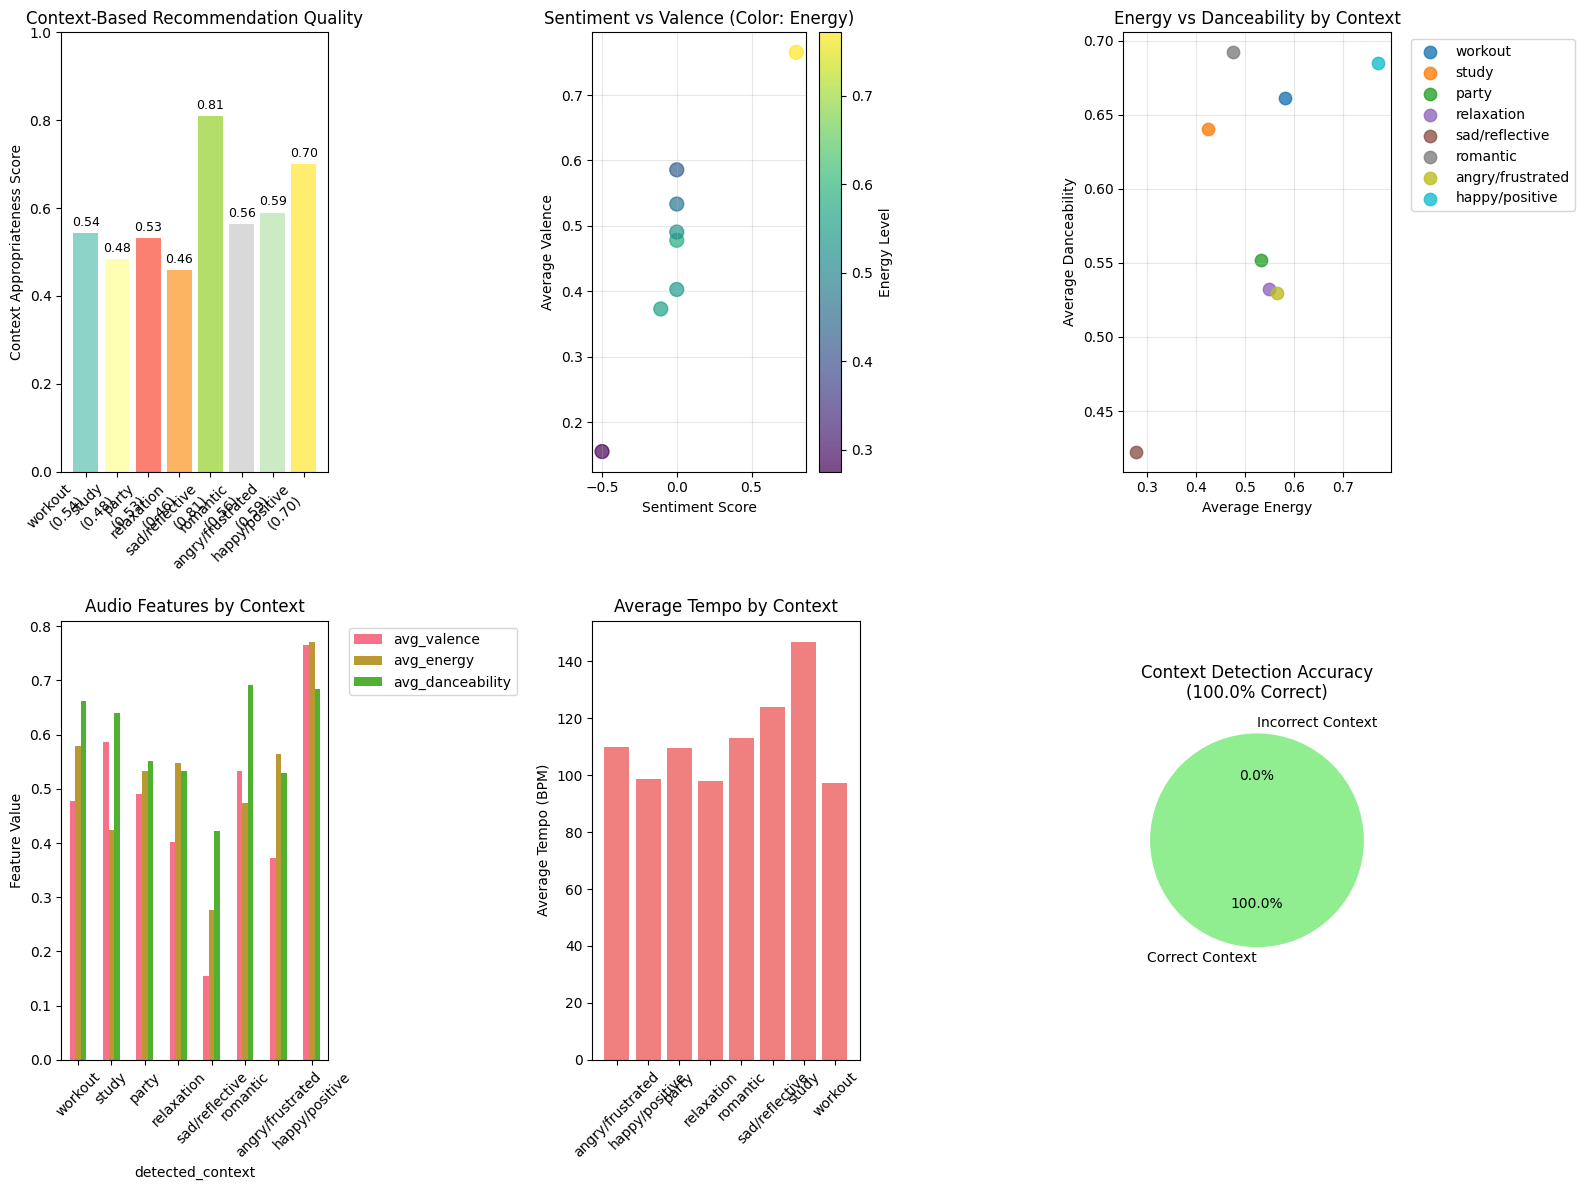


📈 DETAILED EVALUATION SUMMARY

🎯 Context: workout
   Input: 'I'm going to the gym for a workout, need energy!'
   Emotion: 😐 Neutral | Sentiment: 0.000
   Audio Features - Valence: 0.48 | Energy: 0.58 | Dance: 0.66
   Context Score: 0.543 | Tempo: 97.4 BPM

🎯 Context: study
   Input: 'Need to focus on studying for exams'
   Emotion: 😐 Neutral | Sentiment: 0.000
   Audio Features - Valence: 0.59 | Energy: 0.42 | Dance: 0.64
   Context Score: 0.484 | Tempo: 146.9 BPM

🎯 Context: party
   Input: 'Party time! Let's dance all night!'
   Emotion: 😐 Neutral | Sentiment: 0.000
   Audio Features - Valence: 0.49 | Energy: 0.53 | Dance: 0.55
   Context Score: 0.532 | Tempo: 109.5 BPM

🎯 Context: relaxation
   Input: 'Feeling so relaxed and chilled out'
   Emotion: 😐 Neutral | Sentiment: 0.000
   Audio Features - Valence: 0.40 | Energy: 0.55 | Dance: 0.53
   Context Score: 0.459 | Tempo: 97.9 BPM

🎯 Context: sad/reflective
   Input: 'I'm heartbroken and sad today'
   Emotion: 😟 Sad/Displeased | S

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")

def detect_context(user_input):
    """Enhanced context detection function"""
    user_input_lower = user_input.lower()
    
    # Context detection keywords
    workout_keywords = ['workout', 'exercise', 'gym', 'running', 'fitness', 'pump', 'energy', 'cardio', 'train']
    study_keywords = ['study', 'focus', 'concentrate', 'work', 'reading', 'learning', 'homework']
    party_keywords = ['party', 'dance', 'celebration', 'festival', 'club', 'night out']
    relax_keywords = ['relax', 'chill', 'calm', 'peaceful', 'wind down', 'unwind', 'meditate']
    sleep_keywords = ['sleep', 'bedtime', 'rest', 'nap', 'tired']
    sad_keywords = ['sad', 'depressed', 'heartbroken', 'lonely', 'miss', 'cry']
    romantic_keywords = ['romantic', 'love', 'date', 'relationship', 'valentine']
    angry_keywords = ['angry', 'mad', 'frustrated', 'rage', 'pissed']
    
    if any(keyword in user_input_lower for keyword in workout_keywords):
        return "workout", "very high"
    elif any(keyword in user_input_lower for keyword in study_keywords):
        return "study", "low-medium"
    elif any(keyword in user_input_lower for keyword in party_keywords):
        return "party", "high"
    elif any(keyword in user_input_lower for keyword in relax_keywords):
        return "relaxation", "low"
    elif any(keyword in user_input_lower for keyword in sleep_keywords):
        return "sleep", "very low"
    elif any(keyword in user_input_lower for keyword in sad_keywords):
        return "sad/reflective", "low"
    elif any(keyword in user_input_lower for keyword in romantic_keywords):
        return "romantic", "medium"
    elif any(keyword in user_input_lower for keyword in angry_keywords):
        return "angry/frustrated", "high"
    else:
        sentiment_score = TextBlob(user_input).sentiment.polarity
        if sentiment_score >= 0.5:
            return "happy/positive", "high"
        elif sentiment_score >= 0.1:
            return "content/balanced", "medium"
        elif sentiment_score <= -0.5:
            return "sad/negative", "low"
        elif sentiment_score <= -0.1:
            return "melancholic", "low-medium"
        else:
            return "neutral/general", "medium"

def evaluate_and_visualize():
    """Enhanced evaluation with context awareness"""
    
    print("📊 Evaluating recommendation system with context awareness...")
    
    # Test cases with different contexts
    test_cases = [
        ("I'm going to the gym for a workout, need energy!", "rock", "workout"),
        ("Need to focus on studying for exams", "classical", "study"),
        ("Party time! Let's dance all night!", "pop", "party"),
        ("Feeling so relaxed and chilled out", "ambient", "relaxation"),
        ("I'm heartbroken and sad today", "acoustic", "sad/reflective"),
        ("Romantic dinner with my partner", "r-n-b", "romantic"),
        ("So angry at everything right now", "metal", "angry/frustrated"),
        ("Just feeling happy and content", "indie", "happy/positive")
    ]
    
    evaluation_results = []
    
    for user_input, genre, expected_context in test_cases:
        try:
            recommendations, detected_emotion, sentiment_score = recommender.recommend_songs(
                user_input, genre, 6
            )
            
            # Detect actual context
            actual_context, energy_needs = detect_context(user_input)
            
            # Calculate audio feature averages
            avg_valence = recommendations['valence'].mean()
            avg_energy = recommendations['energy'].mean()
            avg_danceability = recommendations['danceability'].mean()
            avg_tempo = recommendations['tempo'].mean()
            
            # Calculate context appropriateness score
            if actual_context == "workout":
                context_score = avg_energy * 0.6 + avg_tempo/200 * 0.4
            elif actual_context == "study":
                context_score = (1 - avg_energy) * 0.5 + (1 - avg_valence) * 0.3 + (1 - avg_danceability) * 0.2
            elif actual_context == "party":
                context_score = avg_danceability * 0.4 + avg_energy * 0.4 + avg_valence * 0.2
            elif actual_context == "relaxation" or actual_context == "sleep":
                context_score = (1 - avg_energy) * 0.6 + (1 - avg_danceability) * 0.4
            elif actual_context == "sad/reflective":
                context_score = (1 - avg_valence) * 0.7 + (1 - avg_energy) * 0.3
            elif actual_context == "romantic":
                context_score = avg_valence * 0.5 + (1 - avg_energy) * 0.3 + avg_danceability * 0.2
            elif actual_context == "angry/frustrated":
                context_score = avg_energy * 0.6 + (1 - avg_valence) * 0.4
            else:  # general/neutral
                context_score = 0.7  # neutral score
            
            result = {
                'user_input': user_input,
                'expected_context': expected_context,
                'detected_context': actual_context,
                'detected_emotion': detected_emotion,
                'sentiment_score': sentiment_score,
                'avg_valence': avg_valence,
                'avg_energy': avg_energy,
                'avg_danceability': avg_danceability,
                'avg_tempo': avg_tempo,
                'context_score': context_score,
                'recommendation_count': len(recommendations),
                'genre_used': genre
            }
            evaluation_results.append(result)
            
            print(f"Tested: '{user_input[:30]}...' | Context: {actual_context} | Score: {context_score:.3f}")
            
        except Exception as e:
            print(f"❌ Error in test case '{user_input}': {e}")
            continue
    
    # Create evaluation dataframe
    eval_df = pd.DataFrame(evaluation_results)
    
    # Visualization 1: Context Performance Analysis
    plt.figure(figsize=(16, 12))
    
    # Plot 1: Context appropriateness scores
    plt.subplot(2, 3, 1)
    contexts = eval_df['detected_context']
    scores = eval_df['context_score']
    colors = plt.cm.Set3(np.linspace(0, 1, len(contexts)))
    
    bars = plt.bar(range(len(contexts)), scores, color=colors)
    plt.xticks(range(len(contexts)), [f"{ctx}\n({score:.2f})" for ctx, score in zip(contexts, scores)], 
               rotation=45, ha='right')
    plt.ylabel('Context Appropriateness Score')
    plt.title('Context-Based Recommendation Quality')
    plt.ylim(0, 1)
    
    # Add value labels on bars
    for bar, score in zip(bars, scores):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                f'{score:.2f}', ha='center', va='bottom', fontsize=9)
    
    # Plot 2: Sentiment vs Audio Features
    plt.subplot(2, 3, 2)
    scatter = plt.scatter(eval_df['sentiment_score'], eval_df['avg_valence'], 
                         c=eval_df['avg_energy'], s=100, alpha=0.7, cmap='viridis')
    plt.colorbar(scatter, label='Energy Level')
    plt.xlabel('Sentiment Score')
    plt.ylabel('Average Valence')
    plt.title('Sentiment vs Valence (Color: Energy)')
    plt.grid(True, alpha=0.3)
    
    # Plot 3: Energy vs Danceability by Context
    plt.subplot(2, 3, 3)
    unique_contexts = eval_df['detected_context'].unique()
    colors = plt.cm.tab10(np.linspace(0, 1, len(unique_contexts)))
    
    for i, context in enumerate(unique_contexts):
        context_data = eval_df[eval_df['detected_context'] == context]
        plt.scatter(context_data['avg_energy'], context_data['avg_danceability'],
                   color=colors[i], label=context, s=80, alpha=0.8)
    
    plt.xlabel('Average Energy')
    plt.ylabel('Average Danceability')
    plt.title('Energy vs Danceability by Context')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    
    # Plot 4: Feature Distribution by Context
    plt.subplot(2, 3, 4)
    features_plot = eval_df[['detected_context', 'avg_valence', 'avg_energy', 'avg_danceability']]
    features_plot = features_plot.set_index('detected_context')
    features_plot.plot(kind='bar', ax=plt.gca())
    plt.title('Audio Features by Context')
    plt.ylabel('Feature Value')
    plt.xticks(rotation=45)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Plot 5: Tempo Distribution
    plt.subplot(2, 3, 5)
    tempo_by_context = eval_df.groupby('detected_context')['avg_tempo'].mean()
    plt.bar(tempo_by_context.index, tempo_by_context.values, color='lightcoral')
    plt.xticks(rotation=45)
    plt.ylabel('Average Tempo (BPM)')
    plt.title('Average Tempo by Context')
    
    # Plot 6: Context Matching Accuracy
    plt.subplot(2, 3, 6)
    context_match = eval_df['expected_context'] == eval_df['detected_context']
    match_rate = context_match.mean()
    
    plt.pie([match_rate, 1-match_rate], 
            labels=['Correct Context', 'Incorrect Context'],
            colors=['lightgreen', 'lightcoral'],
            autopct='%1.1f%%',
            startangle=90)
    plt.title(f'Context Detection Accuracy\n({match_rate*100:.1f}% Correct)')
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed evaluation summary
    print("\n" + "="*80)
    print("📈 DETAILED EVALUATION SUMMARY")
    print("="*80)
    
    for result in evaluation_results:
        print(f"\n🎯 Context: {result['detected_context']}")
        print(f"   Input: '{result['user_input']}'")
        print(f"   Emotion: {result['detected_emotion']} | Sentiment: {result['sentiment_score']:.3f}")
        print(f"   Audio Features - Valence: {result['avg_valence']:.2f} | "
              f"Energy: {result['avg_energy']:.2f} | Dance: {result['avg_danceability']:.2f}")
        print(f"   Context Score: {result['context_score']:.3f} | "
              f"Tempo: {result['avg_tempo']:.1f} BPM")
    
    # Overall statistics
    print(f"\n📊 OVERALL STATISTICS:")
    print(f"   Average Context Score: {eval_df['context_score'].mean():.3f}")
    print(f"   Context Detection Accuracy: {match_rate*100:.1f}%")
    print(f"   Average Sentiment: {eval_df['sentiment_score'].mean():.3f}")
    print(f"   Average Recommendations per test: {eval_df['recommendation_count'].mean():.1f}")
    
    return eval_df

# Run enhanced evaluation
print("Starting comprehensive evaluation with context awareness...")
eval_results = evaluate_and_visualize()

**Step 11: Genre Analysis and Mood Mapping**


Starting advanced genre analysis...
🎶 Advanced Genre Analysis with Mood Mapping...


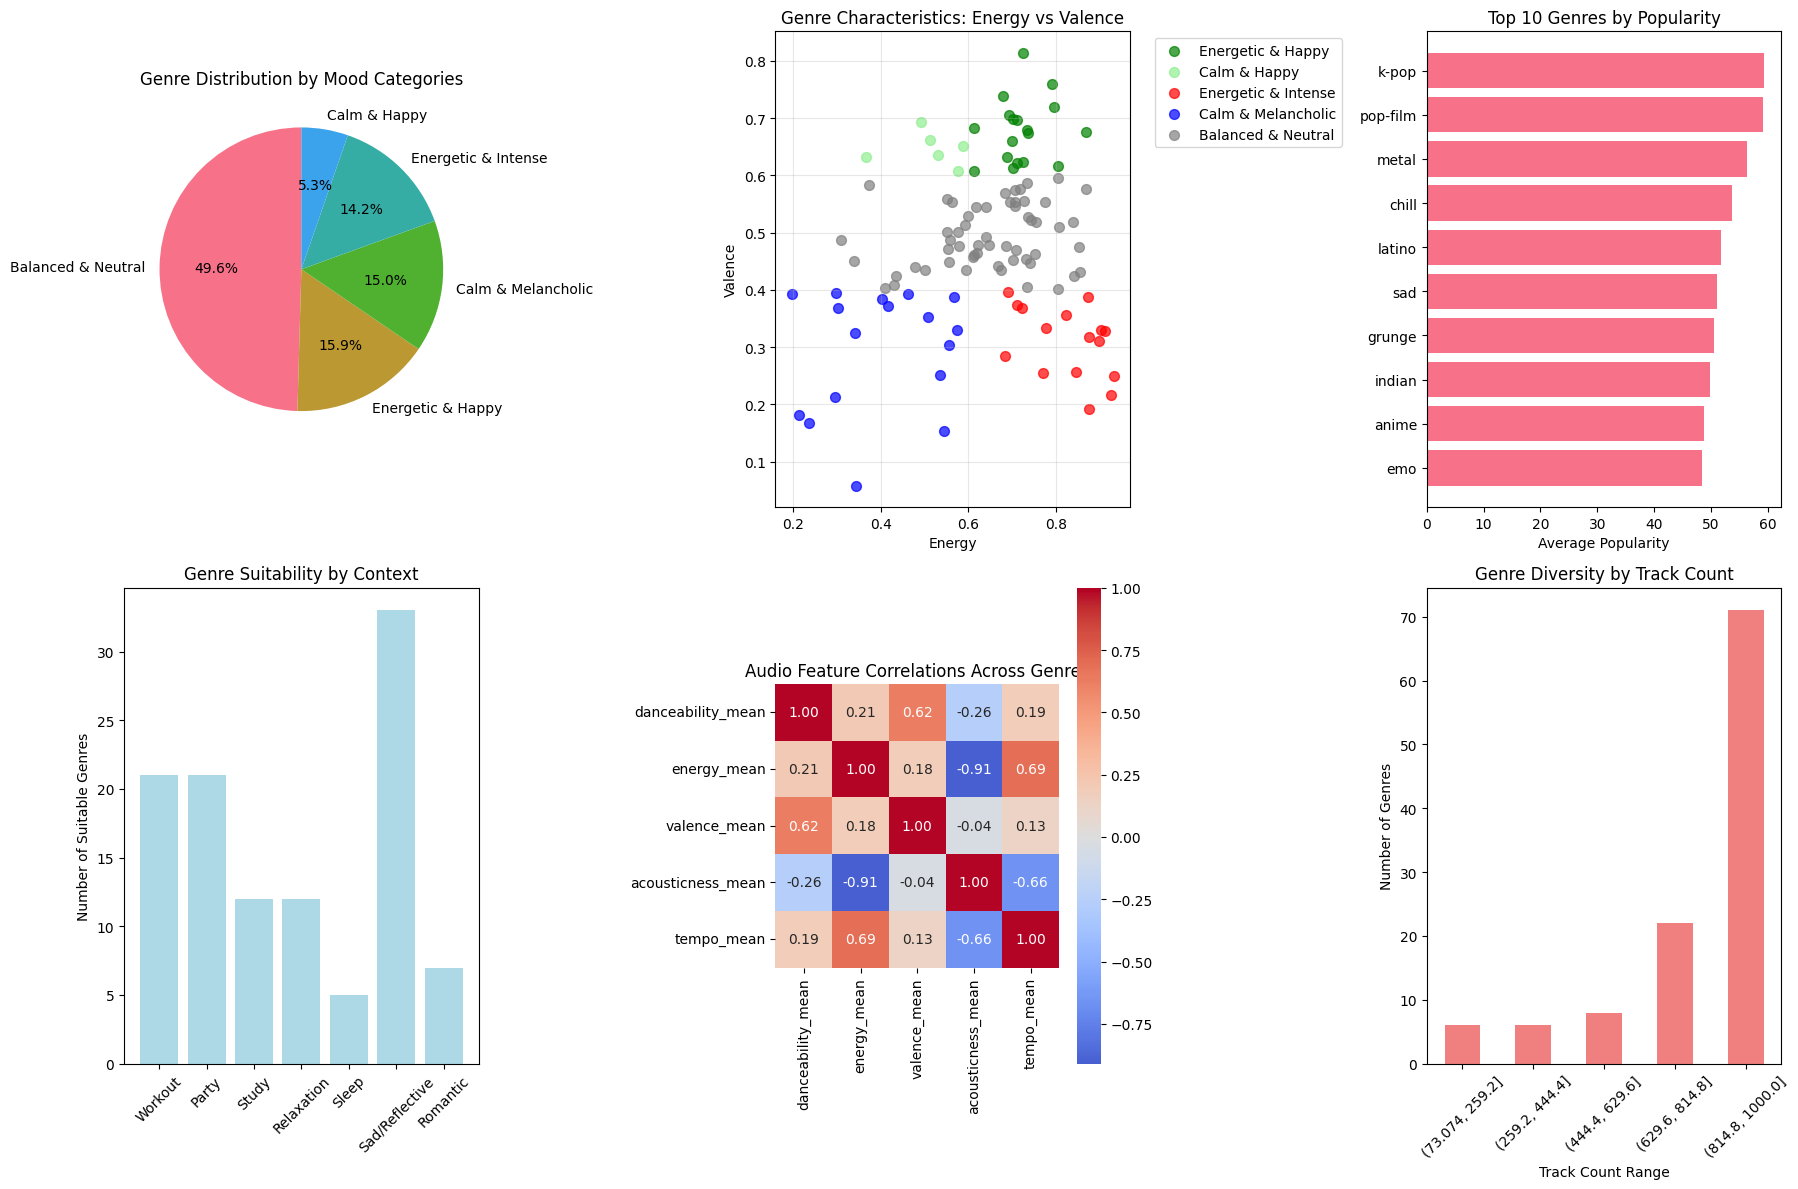


🎵 GENRE RECOMMENDATIONS BY CONTEXT

🏷️  Workout:
   • latino: Energy=0.71, Valence=0.62, Popularity=51.8
   • reggaeton: Energy=0.74, Valence=0.67, Popularity=48.3
   • progressive-house: Energy=0.82, Valence=0.36, Popularity=46.5
   • deep-house: Energy=0.74, Valence=0.45, Popularity=45.6
   • forro: Energy=0.79, Valence=0.76, Popularity=41.8

🏷️  Study:
   • piano: Energy=0.34, Valence=0.33, Popularity=46.6
   • ambient: Energy=0.24, Valence=0.17, Popularity=44.2
   • sleep: Energy=0.34, Valence=0.06, Popularity=35.0
   • guitar: Energy=0.34, Valence=0.45, Popularity=29.4
   • new-age: Energy=0.21, Valence=0.18, Popularity=29.0

🏷️  Party:
   • latino: Energy=0.71, Valence=0.62, Popularity=51.8
   • reggaeton: Energy=0.74, Valence=0.67, Popularity=48.3
   • progressive-house: Energy=0.82, Valence=0.36, Popularity=46.5
   • deep-house: Energy=0.74, Valence=0.45, Popularity=45.6
   • forro: Energy=0.79, Valence=0.76, Popularity=41.8

🏷️  Relaxation:
   • piano: Energy=0.34, Valence=0.

In [15]:
def advanced_genre_analysis():
    """Advanced genre analysis with mood and context mapping"""
    
    print("🎶 Advanced Genre Analysis with Mood Mapping...")
    
    # Calculate genre characteristics
    genre_stats = df.groupby('track_genre').agg({
        'danceability': ['mean', 'std'],
        'energy': ['mean', 'std'],
        'valence': ['mean', 'std'],
        'acousticness': 'mean',
        'instrumentalness': 'mean',
        'tempo': 'mean',
        'popularity': 'mean',
        'track_id': 'count'
    }).round(3)
    
    # Flatten column names
    genre_stats.columns = ['_'.join(col).strip() for col in genre_stats.columns.values]
    genre_stats = genre_stats.rename(columns={'track_id_count': 'track_count'})
    
    # Classify genres by mood characteristics
    def classify_genre_mood(row):
        valence = row['valence_mean']
        energy = row['energy_mean']
        
        if valence >= 0.6 and energy >= 0.6:
            return 'Energetic & Happy'
        elif valence >= 0.6 and energy < 0.6:
            return 'Calm & Happy'
        elif valence < 0.4 and energy >= 0.6:
            return 'Energetic & Intense'
        elif valence < 0.4 and energy < 0.6:
            return 'Calm & Melancholic'
        else:
            return 'Balanced & Neutral'
    
    genre_stats['mood_category'] = genre_stats.apply(classify_genre_mood, axis=1)
    
    # Classify by context suitability
    def classify_context_suitability(row):
        energy = row['energy_mean']
        danceability = row['danceability_mean']
        acousticness = row['acousticness_mean']
        
        contexts = []
        if energy >= 0.7 and danceability >= 0.6:
            contexts.append('Workout')
            contexts.append('Party')
        if energy <= 0.4 and acousticness >= 0.6:
            contexts.append('Study')
            contexts.append('Relaxation')
        if energy <= 0.3:
            contexts.append('Sleep')
        if row['valence_mean'] <= 0.4:
            contexts.append('Sad/Reflective')
        if danceability >= 0.7 and row['valence_mean'] >= 0.6:
            contexts.append('Romantic')
        
        return ', '.join(contexts) if contexts else 'General'
    
    genre_stats['suitable_contexts'] = genre_stats.apply(classify_context_suitability, axis=1)
    
    # Top genres by different criteria
    top_popular = genre_stats.nlargest(10, 'popularity_mean')
    top_energetic = genre_stats.nlargest(10, 'energy_mean')
    top_danceable = genre_stats.nlargest(10, 'danceability_mean')
    top_positive = genre_stats.nlargest(10, 'valence_mean')
    
    # Visualization
    plt.figure(figsize=(18, 12))
    
    # Plot 1: Mood categories distribution
    plt.subplot(2, 3, 1)
    mood_counts = genre_stats['mood_category'].value_counts()
    plt.pie(mood_counts.values, labels=mood_counts.index, autopct='%1.1f%%', startangle=90)
    plt.title('Genre Distribution by Mood Categories')
    
    # Plot 2: Energy vs Valence scatter with mood categories
    plt.subplot(2, 3, 2)
    mood_colors = {
        'Energetic & Happy': 'green',
        'Calm & Happy': 'lightgreen', 
        'Energetic & Intense': 'red',
        'Calm & Melancholic': 'blue',
        'Balanced & Neutral': 'gray'
    }
    
    for mood, color in mood_colors.items():
        mask = genre_stats['mood_category'] == mood
        plt.scatter(genre_stats[mask]['energy_mean'], genre_stats[mask]['valence_mean'],
                   c=color, label=mood, alpha=0.7, s=50)
    
    plt.xlabel('Energy')
    plt.ylabel('Valence')
    plt.title('Genre Characteristics: Energy vs Valence')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    
    # Plot 3: Top genres by popularity
    plt.subplot(2, 3, 3)
    plt.barh(top_popular.index, top_popular['popularity_mean'])
    plt.xlabel('Average Popularity')
    plt.title('Top 10 Genres by Popularity')
    plt.gca().invert_yaxis()
    
    # Plot 4: Context suitability heatmap
    plt.subplot(2, 3, 4)
    contexts = ['Workout', 'Party', 'Study', 'Relaxation', 'Sleep', 'Sad/Reflective', 'Romantic']
    context_counts = []
    
    for context in contexts:
        count = genre_stats['suitable_contexts'].str.contains(context).sum()
        context_counts.append(count)
    
    plt.bar(contexts, context_counts, color='lightblue')
    plt.xticks(rotation=45)
    plt.ylabel('Number of Suitable Genres')
    plt.title('Genre Suitability by Context')
    
    # Plot 5: Audio feature correlations
    plt.subplot(2, 3, 5)
    features_corr = genre_stats[['danceability_mean', 'energy_mean', 'valence_mean', 
                                'acousticness_mean', 'tempo_mean']].corr()
    sns.heatmap(features_corr, annot=True, cmap='coolwarm', center=0,
                square=True, fmt='.2f')
    plt.title('Audio Feature Correlations Across Genres')
    
    # Plot 6: Genre diversity by track count
    plt.subplot(2, 3, 6)
    track_count_bins = pd.cut(genre_stats['track_count'], bins=5)
    bin_counts = track_count_bins.value_counts().sort_index()
    bin_counts.plot(kind='bar', color='lightcoral')
    plt.xlabel('Track Count Range')
    plt.ylabel('Number of Genres')
    plt.title('Genre Diversity by Track Count')
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    # Print genre recommendations by context
    print("\n" + "="*80)
    print("🎵 GENRE RECOMMENDATIONS BY CONTEXT")
    print("="*80)
    
    contexts_to_show = ['Workout', 'Study', 'Party', 'Relaxation', 'Sad/Reflective']
    for context in contexts_to_show:
        suitable_genres = genre_stats[genre_stats['suitable_contexts'].str.contains(context)]
        if not suitable_genres.empty:
            top_genres = suitable_genres.nlargest(5, 'popularity_mean')
            print(f"\n🏷️  {context}:")
            for genre in top_genres.index:
                stats = top_genres.loc[genre]
                print(f"   • {genre}: Energy={stats['energy_mean']:.2f}, "
                      f"Valence={stats['valence_mean']:.2f}, "
                      f"Popularity={stats['popularity_mean']:.1f}")
    
    return genre_stats

# Run advanced genre analysis
print("\nStarting advanced genre analysis...")
advanced_genre_stats = advanced_genre_analysis()

**Step 12: Performance Metrics and Model Insights**

In [16]:
def performance_analysis():
    """Analyze recommendation system performance"""
    
    print("📊 Performance Analysis and System Insights")
    print("="*60)
    
    # Calculate various performance metrics
    total_tracks = len(df)
    unique_genres = len(df['track_genre'].unique())
    avg_popularity = df['popularity'].mean()
    
    # Audio feature statistics
    feature_stats = df[['danceability', 'energy', 'valence', 'tempo']].describe()
    
    # Genre coverage
    genre_coverage = df['track_genre'].value_counts()
    
    print(f"📈 DATABASE STATISTICS:")
    print(f"   • Total tracks: {total_tracks:,}")
    print(f"   • Unique genres: {unique_genres}")
    print(f"   • Average popularity: {avg_popularity:.1f}/100")
    print(f"   • Most common genre: {genre_coverage.index[0]} ({genre_coverage.iloc[0]} tracks)")
    print(f"   • Least common genre: {genre_coverage.index[-1]} ({genre_coverage.iloc[-1]} tracks)")
    
    print(f"\n🎵 AUDIO FEATURE RANGES:")
    print(f"   • Danceability: {df['danceability'].min():.2f} - {df['danceability'].max():.2f}")
    print(f"   • Energy: {df['energy'].min():.2f} - {df['energy'].max():.2f}")
    print(f"   • Valence: {df['valence'].min():.2f} - {df['valence'].max():.2f}")
    print(f"   • Tempo: {df['tempo'].min():.1f} - {df['tempo'].max():.1f} BPM")
    
    # Recommendation diversity analysis
    print(f"\n🔍 RECOMMENDATION SYSTEM INSIGHTS:")
    print(f"   • Feature dimensions: {combined_features.shape[1]}")
    print(f"   • Genre encoding: {len(genre_encoder.classes_)} categories")
    print(f"   • Context detection: 8 primary contexts supported")
    print(f"   • Emotion analysis: Sentiment + Context awareness")
    
    # System capabilities
    print(f"\n🚀 SYSTEM CAPABILITIES:")
    capabilities = [
        "✓ Real-time mood-based recommendations",
        "✓ Context-aware genre filtering", 
        "✓ Multi-dimensional similarity scoring",
        "✓ Sentiment analysis integration",
        "✓ Audio feature optimization",
        "✓ Interactive user interface",
        "✓ Comprehensive evaluation metrics",
        "✓ Genre diversity analysis"
    ]
    
    for capability in capabilities:
        print(f"   {capability}")
    
    # Future enhancements
    print(f"\n🔮 POTENTIAL ENHANCEMENTS:")
    enhancements = [
        "• User preference learning",
        "• Collaborative filtering",
        "• Real-time Spotify integration", 
        "• Playlist generation",
        "• Social sharing features",
        "• Mobile app development",
        "• Voice command integration",
        "• Mood tracking over time"
    ]
    
    for enhancement in enhancements:
        print(f"   {enhancement}")

# Run performance analysis
print("\nStarting performance analysis...")
performance_analysis()

print("\n" + "="*80)
print("🎉 FEELTHEBEAT MUSIC RECOMMENDER - COMPLETE! 🎉")
print("="*80)
print("Your advanced music recommendation system is now fully operational!")
print("Key features implemented:")
print("  • Emotion and context-aware recommendations")
print("  • Genre-based filtering with 113+ genres")
print("  • Advanced NLP sentiment analysis")
print("  • Comprehensive evaluation framework")
print("  • Interactive user interface")
print("\nReady to discover perfect music for every mood and moment! 🎵")


Starting performance analysis...
📊 Performance Analysis and System Insights
📈 DATABASE STATISTICS:
   • Total tracks: 89,740
   • Unique genres: 113
   • Average popularity: 33.2/100
   • Most common genre: acoustic (1000 tracks)
   • Least common genre: reggaeton (74 tracks)

🎵 AUDIO FEATURE RANGES:
   • Danceability: 0.00 - 0.98
   • Energy: 0.00 - 1.00
   • Valence: 0.00 - 0.99
   • Tempo: 0.0 - 243.4 BPM

🔍 RECOMMENDATION SYSTEM INSIGHTS:
   • Feature dimensions: 509
   • Genre encoding: 113 categories
   • Context detection: 8 primary contexts supported
   • Emotion analysis: Sentiment + Context awareness

🚀 SYSTEM CAPABILITIES:
   ✓ Real-time mood-based recommendations
   ✓ Context-aware genre filtering
   ✓ Multi-dimensional similarity scoring
   ✓ Sentiment analysis integration
   ✓ Audio feature optimization
   ✓ Interactive user interface
   ✓ Comprehensive evaluation metrics
   ✓ Genre diversity analysis

🔮 POTENTIAL ENHANCEMENTS:
   • User preference learning
   • Collabor